1.Cargando la información y librerias

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Configuration para visualización de filas y de columnas
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 100)

# Cargando el archivo .csv. El archivo corresponde a la información de la ciudad de Buenos Aires, Argentina
listings_df = pd.read_csv("./data/listings.csv.gz")

2.Información de la base de datos

In [6]:
# Dimensiones de la base de datos
listings_df.shape

(26204, 75)

In [8]:
#  Registros unicos
listings_df["id"].nunique()

26204

In [7]:
# Tipos de las columnas/atributos de la base de datos
listings_df.dtypes

id                                                int64
listing_url                                      object
scrape_id                                         int64
last_scraped                                     object
source                                           object
name                                             object
description                                      object
neighborhood_overview                            object
picture_url                                      object
host_id                                           int64
host_url                                         object
host_name                                        object
host_since                                       object
host_location                                    object
host_about                                       object
host_response_time                               object
host_response_rate                               object
host_acceptance_rate                            

In [ ]:
# Muestra un ejemplo, de 5 filas
listings_df.sample(5) 

Como se evidencia, en las anteriores lineas de codigo, la base de datos cuenta con 26204 registros en la base de datos, lo cual implica que contamos con la información de 26204 predios en la ciudad de Buenos Aires Argentina, inscritos en la plataforma de AirBNB. Tenemos 75 atributos para esta base de datos, los cuales cuentan con información clave como es:

        - Host de los predios
        - Información de los predios (Cantidad de baños, capacidad, tipo de predio, geolocalización, barrio, amenidades)
        - Valor por noche de cada predio
        - Cantidad de noches promedio por predio en diferentes intervalos de tiempo
        - Review de los predios

Ya que el objetivo del siguiente analisis es obtener información relevante acerca de la rentabilidad esperada que puede tener un predio en la ciudad de Buenos Aires, nos centraremos en algunos atributos especificos, cuya relevancai sera exzplicada mas adelante. Los atributos consdierados mas relevantes seran:

        Atributo                    Contenido                                                                                                   Tipo
        - "price":                  Corresponde al precio por noche del predio, se encuentra en moneda local                                    Object
        - "room_type"               Corresponde al tipo de predio. Se divide entre "Entire place", "Private Room" y "Shared Room".              Object
        - "bedrooms":               Cantidad de habitaciones                                                                                    float
        - "availability_xx":        Este corresponden a la disponibilidad del predio en los ultimos xx dias.                                    Integer
        - "number_of_reviews_ltm":  Corresponde a la cantidad de reviews que ha tenido el predio en el ultimo año                               Integer
        - "neighbourhood_cleansed": Barrio del predio                                                                                           Object
        - Variables de review:      Set de variables que determinan comportamientos claves de la forma en la que se comportan los reviews (Su aproximación se hara en la parte multivariada)

3.Analisis Univariado

    3.1 Price:


In [ ]:
#Ejemplo de price
listings_df["price"].sample(5) 

In [21]:
# Considerando que este cuenta con valores no numericos, se transforma con la siguiente linea a un valor tipo float. Se añade la columna "price_float"
listings_df["price_float"] = listings_df["price"].str.replace("[$,]", "", regex=True).astype(float)

In [58]:
#Distribución por percentiles
listings_df["price_float"].describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.9, 0.95])

count    2.620400e+04
mean     1.752933e+04
std      1.754018e+05
min      1.750000e+02
5%       4.331000e+03
25%      7.406500e+03
50%      1.019000e+04
75%      1.528600e+04
90%      2.456600e+04
95%      3.397675e+04
max      2.529509e+07
Name: price_float, dtype: float64

In [34]:
#Como se evidencia anteriormente, se cuenta con valores muy altos y probablemente atipicos en el precio de los predios. Se procede a organizarlos de acuerdo a esto, junto con otros atributos, para determinar si corresponde a predios 
#particularmente grandes
listings_df[["accommodates", "bathrooms_text", "bedrooms", "price_float"]].sort_values(by=["price_float"])

,accommodates,bathrooms_text,bedrooms,price_float
4373,1,1 shared bath,NaN,175.0
963,2,1 bath,1.0,260.0
2971,1,1.5 baths,NaN,400.0
5009,1,1 shared bath,NaN,450.0
3994,1,1 private bath,NaN,500.0
...,...,...,...,...
25302,3,1 bath,1.0,3799230.0
9020,2,1 bath,1.0,4036994.0
13132,1,1 shared bath,NaN,4500000.0
14401,3,1 bath,1.0,4568081.0


In [61]:
#Como se evidencia anteriormente, no correspoonde a predios particularmente grandes. Se procede a realizar anexar una variable de tipo boolean, donde se tendran valores True a los predios que esten dentro del rango
#<=(q3 + 3*(q3-q1))

q1 = listings_df["price_float"].quantile(0.25)
q3 = listings_df["price_float"].quantile(0.75)
listings_df["On_Price_Q1-Q3_Range"] = listings_df["price_float"] <= (q3 + 3 * (q3-q1))
listings_df["On_Price_Q1-Q3_Range"].value_counts(dropna=False, normalize=True)

On_Price_Q1-Q3_Range
True     0.963822
False    0.036178
Name: proportion, dtype: float64

count    25256.000000
mean     11772.415505
std       6782.258376
min        175.000000
25%       7309.750000
50%       9936.000000
75%      14215.500000
max      38837.000000
Name: price_float, dtype: float64

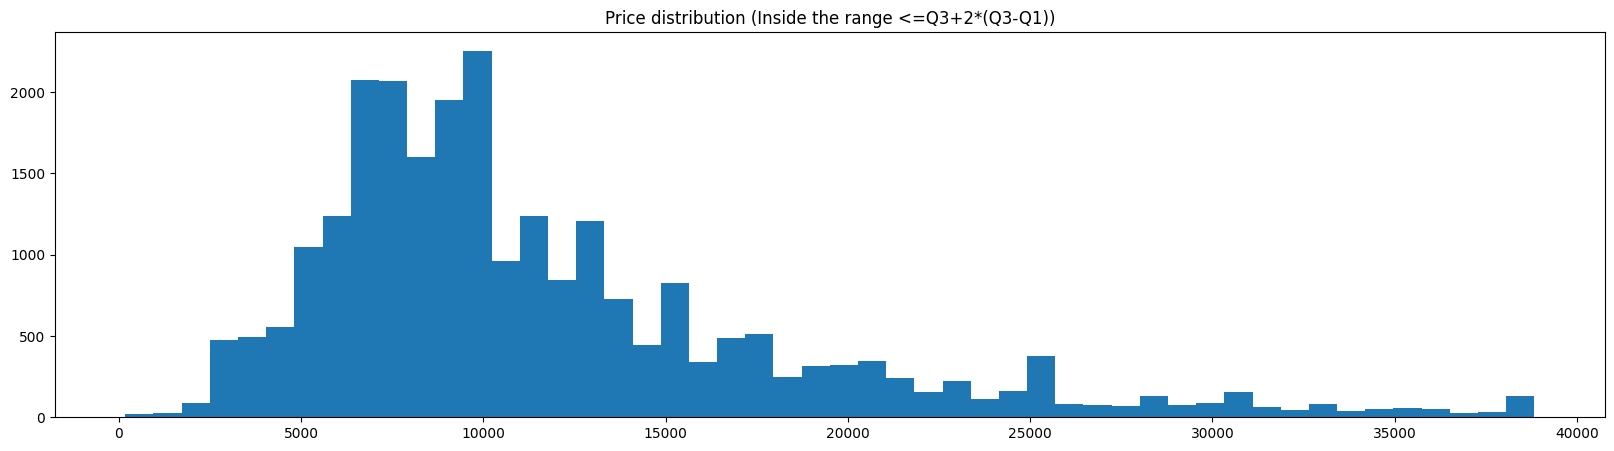

In [70]:
#A patir de esto, se grafica un histograma para ver la distribución de precios
plt.figure(figsize=(20, 5))
plt.hist(listings_df.loc[listings_df["On_Price_Q1-Q3_Range"]]["price_float"], bins=50)
plt.title("Distribución del precio (Dentro del rango <=Q3+2*(Q3-Q1))")
plt.plot()
listings_df.loc[listings_df["On_Price_Q1-Q3_Range"]]["price_float"].describe(percentiles=[0.25, 0.5, 0.75])


Como se evidencia en el analisis univariado anterior, el precio requeria de diversas correcciones entre ellas, la correción del tipo de dato para facilitar y permitir su analisis. Por otro lado fue necesario marcar los registros con valores por fuera del rango de Q1 + 3*(Q3-Q1), dado que en el percentil 95% teniamos valores que rondaban el orden de maginutd de 1*10e4, sin embargo el valor maximo estaba 3 ordenes de magnitud por encima, estos valores probablemente atipicos iban a increementar considerablemente el promedio y la varianza de la medida, afectando el analisis. 

Posteriormente, se grafico el histograma de la distribución y se calculo la media aritmetica y la desviación estandar, mostrando que la media de los valores esta en 11722.41 ARS con una desviación estandar de 6782.25 ARS. Considerando el rango [media - 1 desviacion estandar, Media + 1 desvaicion estandar], la mayor parte de datos esta entre 4990.15 y 18554.67 ARS. En terminos de percentiles, el 75% de los datos muestra valores inferiores a 14215.5 ARS

De aqui en adelante, se considerara para el analisis, solo los valores que esten en el rango de precio Q1 + 3*(Q3-Q1). Esto considerando que el precio es el eje fundamental del presente analisis

    3.2 Room_type:

Al ser una variable de tipo OBJECT/STRING, vamos a determinar los valores unicos, y ver su distribución

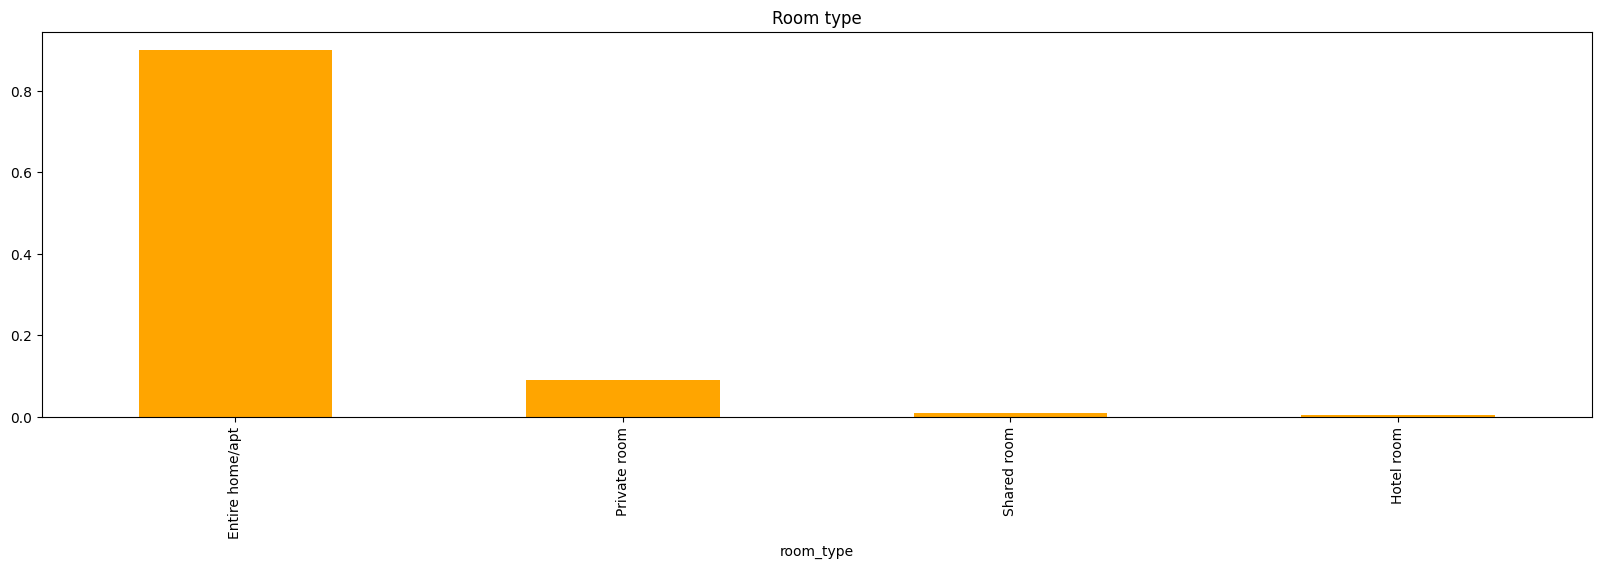

room_type
Entire home/apt    23556
Private room        2343
Shared room          206
Hotel room            99
Name: count, dtype: int64

In [166]:
#grafica de tipo barra de los valores normalizados de cada tipo de habitación
plt.figure(figsize=(20, 5))
listings_df.loc[listings_df["On_Price_Q1-Q3_Range"]]["room_type"].value_counts(dropna=False, normalize=True).plot(kind="bar", color="orange")
plt.title("Room type")
plt.show()

listings_df["room_type"].value_counts(dropna=False, normalize=False) 


Como se evidencia anteriormente, casi el 90% de los predios corresponden a casas o apartamentos enteros, cerca del 9% corresponden a cuartos privados. Por ende un poco mas del 1% corresponde a habitaciones compartidas y cuartos de hotel. Considernado la información obtenida, centraremos nuestro analisis en casas o apartamentos enteros o en cuartos privados

    3.3 Bedrooms

count    19807.000000
mean         1.303024
std          0.684476
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
90%          2.000000
95%          2.000000
99%          3.000000
max         35.000000
Name: bedrooms, dtype: float64
count    19780.000000
mean         2.951517
std          1.186414
min          1.000000
25%          2.000000
50%          3.000000
75%          4.000000
90%          4.000000
95%          5.000000
99%          6.000000
max         16.000000
Name: accommodates, dtype: float64


[]

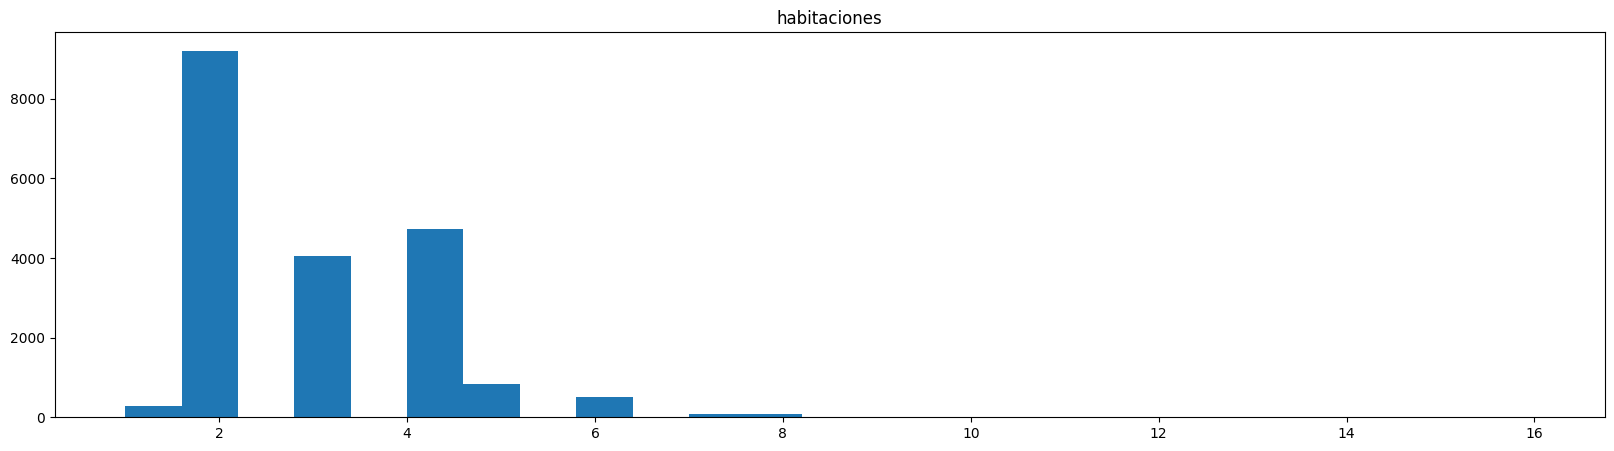

In [187]:
#Distribución por percentiles y valores estadisticos de la cantidad de habitaciones
print(listings_df.loc[listings_df["On_Price_Q1-Q3_Range"]]["bedrooms"].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99]))

#Se cambia el valor, a incluir los valores que se encuentran dentro del rango <= q3+3*(q3-q))
q1 = listings_df["bedrooms"].quantile(0.25)
q3 = listings_df["bedrooms"].quantile(0.75)
iqr = q3-q1

#Distribución por percentiles y valores estadisticos
print(listings_df.loc[(listings_df["bedrooms"]<= q3+3*iqr)&(listings_df["On_Price_Q1-Q3_Range"])]["accommodates"].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99]))

#Histograma de distribución
plt.figure(figsize=(20, 5))
plt.hist(listings_df.loc[(listings_df["bedrooms"]<= q3+3*iqr)&(listings_df["On_Price_Q1-Q3_Range"])]["accommodates"], bins=25)
plt.title("# de Habitaciones")
plt.plot()


In [ ]:
#Valores unicos en el atributo bedrooms
listings_df["bedrooms"].value_counts(dropna=False, normalize=True).cumsuym

In [216]:
#Calculo del estimativo de camas por habitación
a = (listings_df.loc[listings_df["On_Price_Q1-Q3_Range"]]["beds"]/listings_df.loc[listings_df["On_Price_Q1-Q3_Range"]]["bedrooms"]).value_counts(normalize=True)
print(a)
Estimado_habitaciones = (a[1]*1+a[2]*2+a[3]*1.5)/(a[1]+a[2]+a[3])
print(Estimado_habitaciones)


1.000000     0.551449
2.000000     0.228317
1.500000     0.088612
3.000000     0.065531
4.000000     0.016624
1.333333     0.014540
0.500000     0.008287
1.666667     0.007728
2.500000     0.006965
5.000000     0.001525
6.000000     0.001423
0.333333     0.001322
1.250000     0.001271
0.250000     0.000966
0.666667     0.000763
14.000000    0.000763
2.333333     0.000559
10.000000    0.000458
2.666667     0.000407
3.500000     0.000356
0.142857     0.000356
1.750000     0.000203
7.000000     0.000153
0.125000     0.000153
0.090909     0.000102
0.071429     0.000102
0.166667     0.000102
0.800000     0.000102
1.800000     0.000102
0.100000     0.000051
3.333333     0.000051
9.000000     0.000051
4.500000     0.000051
3.666667     0.000051
3.800000     0.000051
0.750000     0.000051
1.428571     0.000051
1.833333     0.000051
0.833333     0.000051
0.428571     0.000051
4.666667     0.000051
5.500000     0.000051
0.200000     0.000051
2.250000     0.000051
Name: proportion, dtype: float64

In [228]:
#Generación de la columna bedrooms_modified donde se contempla el caluclo para el caso que se tienen NaN
listings_df["bedroom_modified"]=listings_df["bedrooms"]
listings_df.loc[listings_df["bedrooms"].isna(),"bedrooms_modified"] = round(listings_df["beds"]/Estimado_habitaciones)
print(listings_df.loc[(listings_df["On_Price_Q1-Q3_Range"])]["bedrooms_modified"].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99]))
#print(listings_df.loc[(listings_df["On_Price_Q1-Q3_Range"])]["bedrooms"].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99]))

#Se cambia el valor, a incluir los valores que se encuentran dentro del rango <= q3+3*(q3-q))
q1 = listings_df["bedrooms_modified"].quantile(0.25)
q3 = listings_df["bedrooms_modified"].quantile(0.75)
iqr = q3-q1

#Distribución por percentiles y valores estadisticos
print(listings_df.loc[(listings_df["bedrooms_modified"]<= q3+3*iqr)&(listings_df["On_Price_Q1-Q3_Range"])]["bedrooms_modified"].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99]))


count    24945.000000
mean         1.283544
std          0.723619
min          0.666667
25%          0.666667
50%          1.000000
75%          2.000000
90%          2.000000
95%          2.666667
99%          4.000000
max          6.000000
Name: bedrooms_modified, dtype: float64
count    24945.000000
mean         1.283544
std          0.723619
min          0.666667
25%          0.666667
50%          1.000000
75%          2.000000
90%          2.000000
95%          2.666667
99%          4.000000
max          6.000000
Name: bedrooms_modified, dtype: float64


In [227]:
#A partir de lo previamente visualizado, se procecede a modificar la columna On_Price_Q1-Q3_Range para incluir los registros que se encuentren en este rango para los atributos price y bedrooms_modified
listings_df.loc[listings_df["On_Price_Q1-Q3_Range"],"On_Price_Q1-Q3_Range"] = listings_df["bedrooms_modified"]<= q3+3*iqr
listings_df["On_Price_Q1-Q3_Range"].value_counts()

On_Price_Q1-Q3_Range
True     24945
False     1259
Name: count, dtype: int64

Como se evidencio anteriormente, se realizo el analisis univariado del atributo bedrooms, donde se encontro que mas del 20% de los valores son NaN. Por ende, se realiza una transformación en una columna nuea, en la cual se determina el valor de las habitaciones como la cantidad de camas, sobre el estimado de camas que hay por habitación, claramente solo para los valores de Nan. Este consolidado se obtuvo como el promedio ponderado de la cantidad de camas por habitación, del 90% de los valores.

Depues de esta transformación, se evidencia que los valores de Media y desviación estandar no cambiaron significativamente

Se muestra que el 99% de los predios tienen al menos 4 habitaciones, y al menos el 75% tiene por lo menos dos habitaciones

    3.4 availability_365  y  number_of_reviews_ltm

In [251]:
#Información estadistica 
print(listings_df.loc[listings_df["On_Price_Q1-Q3_Range"]]["availability_365"].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99]))
print(listings_df.loc[listings_df["On_Price_Q1-Q3_Range"]]["number_of_reviews_ltm"].describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95, 0.99]))

count    24945.000000
mean       213.431670
std        127.142223
min          0.000000
25%         89.000000
50%        224.000000
75%        341.000000
90%        362.000000
95%        365.000000
99%        365.000000
max        365.000000
Name: availability_365, dtype: float64
count    24945.000000
mean         9.753899
std         14.094642
min          0.000000
25%          0.000000
50%          4.000000
75%         14.000000
90%         28.000000
95%         38.000000
99%         60.000000
max        377.000000
Name: number_of_reviews_ltm, dtype: float64


[]

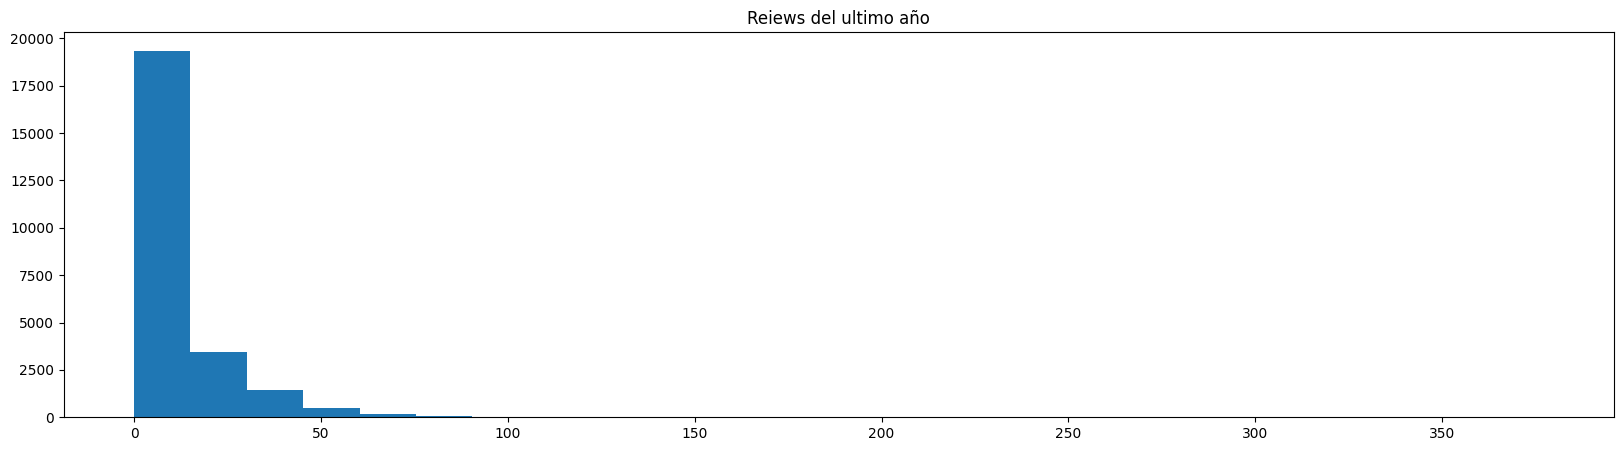

In [256]:
#Histograma numero de reviews
plt.figure(figsize=(20, 5))
plt.hist(listings_df.loc[(listings_df["On_Price_Q1-Q3_Range"])]["number_of_reviews_ltm"], bins=25)
plt.title("Reviews del ultimo año")
plt.plot()

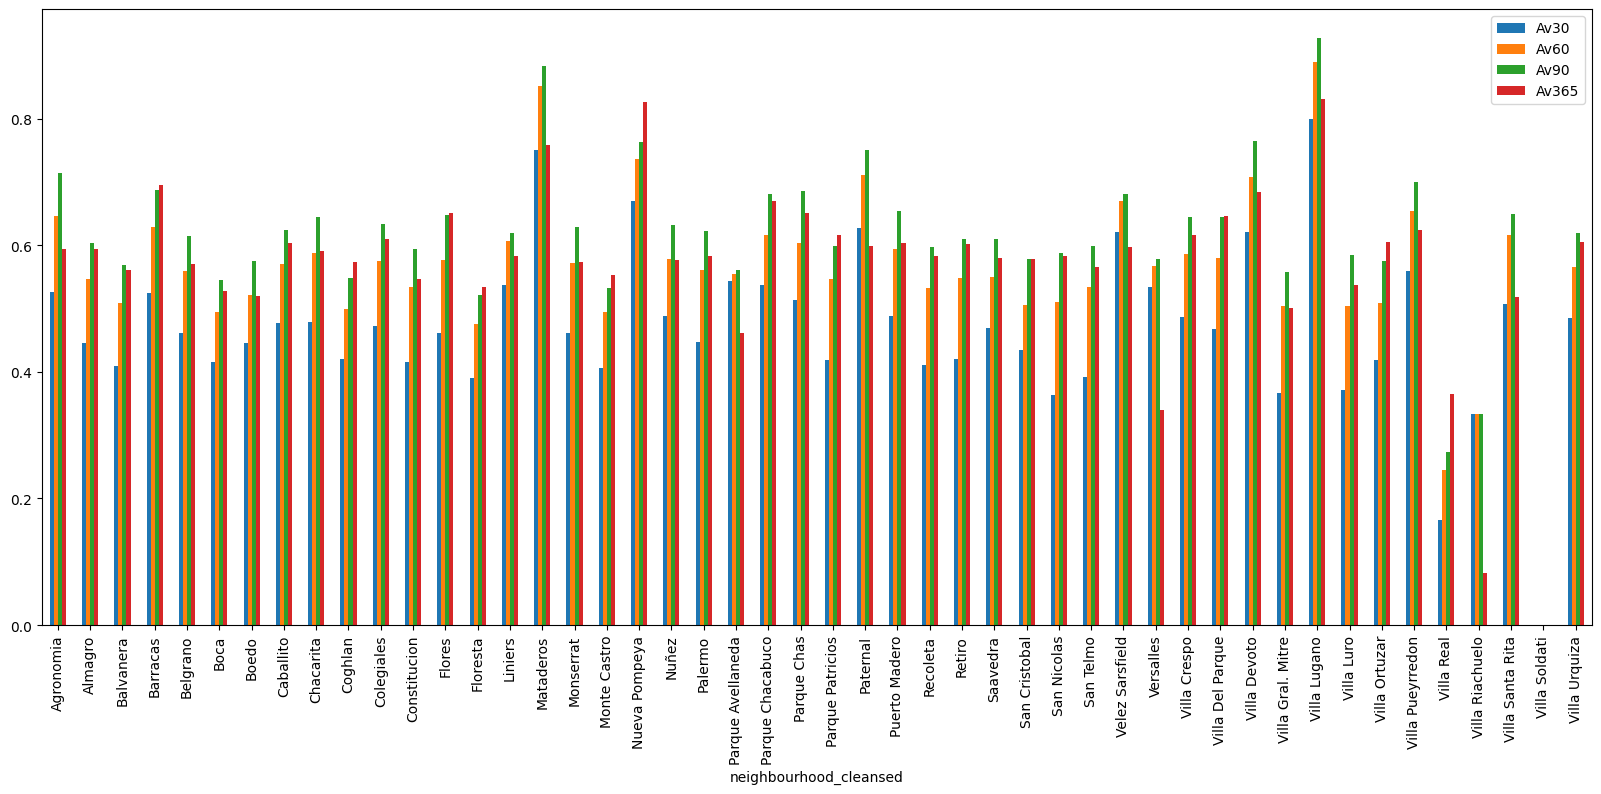

In [274]:
#Histograma disponibilidad del ultimo año
Data = {"Av30": listings_df.groupby(["neighbourhood_cleansed"])["availability_30"].mean()/30,
        "Av60": listings_df.groupby(["neighbourhood_cleansed"])["availability_60"].mean()/60,
        "Av90": listings_df.groupby(["neighbourhood_cleansed"])["availability_90"].mean()/90,
        "Av365": listings_df.groupby(["neighbourhood_cleansed"])["availability_365"].mean()/365}

df_Availability = pd.DataFrame(Data,columns=['Av30', 'Av60', 'Av90', 'Av365'])

fig, ax1 = plt.subplots(1, 1, figsize=(20, 8))
df_Availability.plot.bar(ax = ax1)
plt.show()

Como se puede evidenciar anteriormente, las variables de availability_365 y number_of_reviews_ltm, presentan una distribución orientada a mayor disponibilidad a lo largo del año, es decir, la mayoria de predios matienen alta disponibilidad a lo largo del año, lo cual va acompañado de una pequeña cantidad de review en la mayoria de predios. Estas dos variables entraran a definir un papel crucial en al demanda y oferta de los predios. 

    3.5 neighbourhood_cleansed

In [258]:
#Display de la totalidad de barrios contenidos en la base de datos
print(listings_df["neighbourhood_cleansed"].unique())
print(listings_df["neighbourhood_cleansed"].nunique())

['Palermo' 'Recoleta' 'Nuñez' 'Monserrat' 'Balvanera' 'Retiro'
 'Constitucion' 'Barracas' 'San Nicolas' 'Chacarita' 'Almagro'
 'Puerto Madero' 'Villa Crespo' 'Belgrano' 'Coghlan' 'Parque Chacabuco'
 'San Cristobal' 'Villa Urquiza' 'San Telmo' 'Boedo' 'Colegiales' 'Boca'
 'Caballito' 'Villa Luro' 'Villa Devoto' 'Saavedra' 'Flores'
 'Monte Castro' 'Villa Ortuzar' 'Villa Gral. Mitre' 'Velez Sarsfield'
 'Parque Patricios' 'Villa Del Parque' 'Floresta' 'Paternal'
 'Villa Pueyrredon' 'Villa Santa Rita' 'Liniers' 'Agronomia'
 'Parque Avellaneda' 'Villa Real' 'Parque Chas' 'Villa Lugano' 'Versalles'
 'Nueva Pompeya' 'Villa Riachuelo' 'Villa Soldati' 'Mataderos']
48


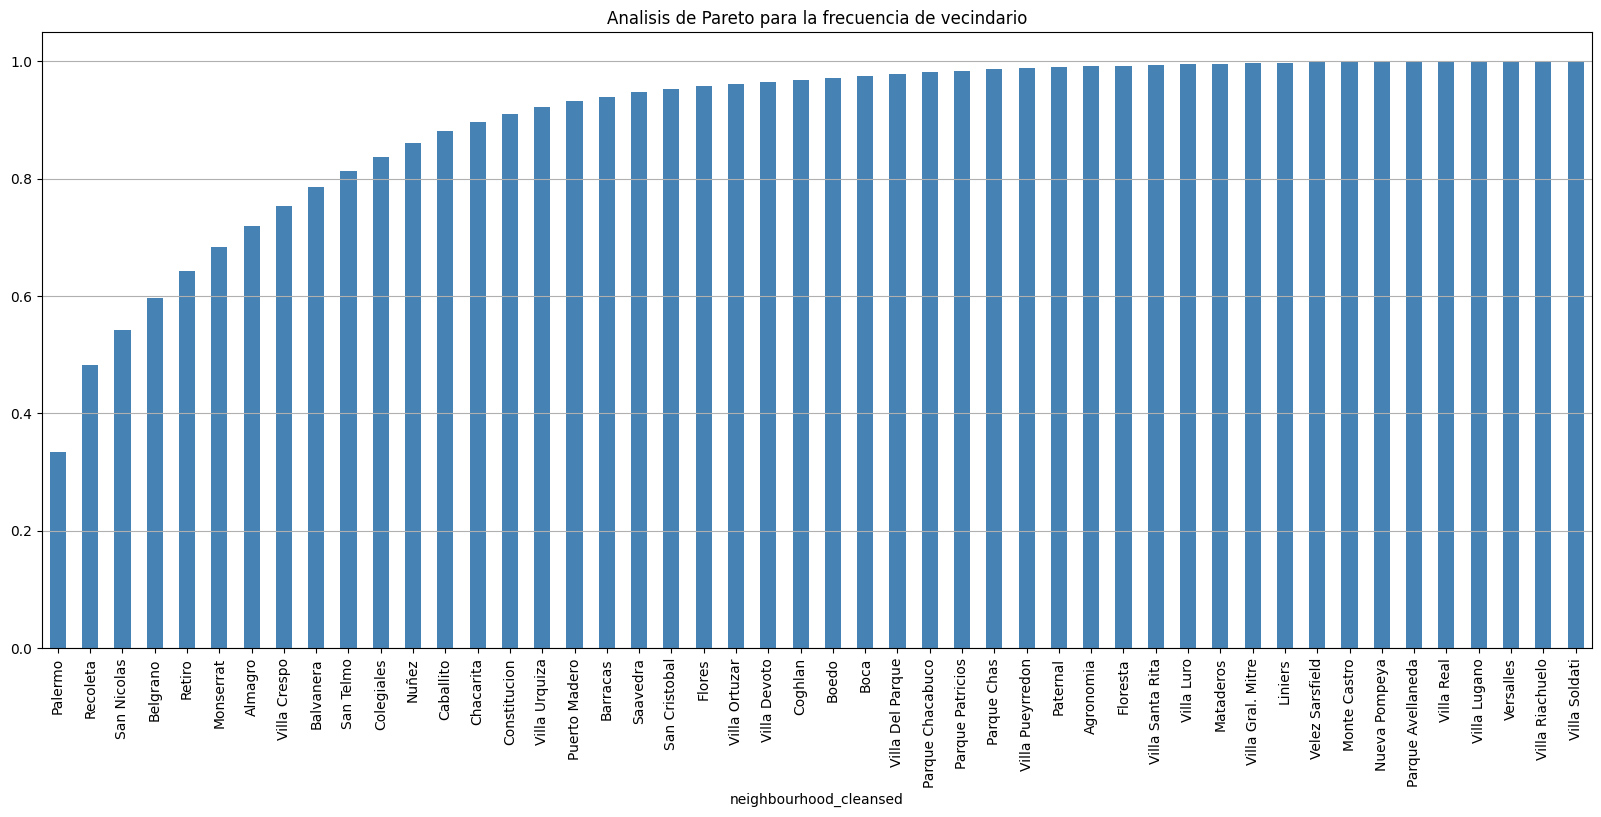

In [261]:
#Analisis de Pareto
neighbourhood_frec_cumsum = listings_df.loc[listings_df["On_Price_Q1-Q3_Range"]]["neighbourhood_cleansed"].value_counts(normalize=True).cumsum()
plt.figure(figsize=(20, 8))
neighbourhood_frec_cumsum.plot(kind="bar", color="steelblue")
plt.title("Analisis de Pareto para la frecuencia de vecindario")
plt.grid(axis="y")
plt.show()

In [273]:
#Barrios representativos
most_representative_neighbourhoods = neighbourhood_frec_cumsum.loc[neighbourhood_frec_cumsum < 0.8].index.tolist()
print(len(most_representative_neighbourhoods))
print(most_representative_neighbourhoods)

9
['Palermo', 'Recoleta', 'San Nicolas', 'Belgrano', 'Retiro', 'Monserrat', 'Almagro', 'Villa Crespo', 'Balvanera']


Como se evidencia anteriormente, la variable neighbourhood_cleansed determina la ubicación por barrio en la cual esta ubicada el inmueble. La base de datos contempla los48 barrios de la ciudad de Buenos Aires Argentina. Como podemos ver en el analisis de Pareto, a pesar de que se tienen 48 barrios en total, el 80% de los predios se encuentra ubicado solo en 9, siendo estos>

'Palermo', 'Recoleta', 'San Nicolas', 'Belgrano', 'Retiro', 'Monserrat', 'Almagro', 'Villa Crespo', 'Balvanera'

Siendo el mas popular de todos Palermo, con mas del 35% de la totalidad de los inmuebles. Apriori se podria pensar que estos predios estan ubicados cerca de las zonas mas turisticas, o cerca a grandes centros empresariales. 



4.Analisis Multivariado

    4.1 Estrategia

La estrategia propuesta para la identificación de las mejores oportuinidades de inversión en la cidudad de Buenos Aires, parte de dos importantes fuentes de información.

La primera es el mismo AirBNB que contempla toda la información aqui analizada, asi como una calculadora de rendimiento esperado para diferentes tipos de predios en cada ciudad del mundo. Este se calcula a traves del valor de cada noche en el inmueble, multiplicado por 365 dias años. Posteriormente este valor se multiplica for el inverso de la disponibilidad, lo cual nos da un estimado, de la cantidad de noches que el predio podria mantenerse ocupado, acorde a la información del ultimo año. Basado en esta información es posible generar un estimativo del ingreso anual que generaria un inmueble. 

Por otro lado, utilizando información de fuentes de datos de inmobiliarias ampliamente conocidas en Argentina, se estima el valor del m2 en Buenos Aires, asi como una distribución del area requerida por cantidad de habitaciones en los inmuebles. Con esta información, junto con la información generada anteriormente, es posible generar estimativos de inversion, como puede ser VAN, TIR, ROI, etc para estimar las mejores oportunidades de adquisición con el mayor rendimiento o o el menor tiempo de retorno de la inversión.

Junto con la información generada, tambien se encontraran posibles correlaciones entre el tipo de vivienda, las amenidades, la localización y las variables economicas recien generadas, lo que nos permitira dar el mayor posible rendimiento